In [1]:
import brian2
from brian2tools import *
from brian2 import *
from struct import unpack
from PIL import Image
import numpy as np
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import os.path
import pickle as pickle
import scipy
import scipy.signal as signal
import time
import warnings
warnings.simplefilter('ignore')
import gc
gc.collect()

1437

In [2]:
def gaussian2D(x, y, sigma):
    return (1.0/(1*math.pi*(sigma**2)))*math.exp(-(1.0/(sigma**2))*(x**2 + y**2))

def mexicanHat(x,y,sigma1,sigma2): 
    return gaussian2D(x,y,sigma1) - gaussian2D(x,y,sigma2)

def receptiveFieldMatrix(func):
    h = 7
    g = np.zeros((h,h))
    for xi in range(0,h):
        for yi in range(0,h):
            x = xi-int(h/2)
            y = yi-int(h/2)
            g[xi, yi] = func(x,y);
    return g

In [3]:
def get_matrix_from_file(fileName, shape):
    readout = np.load(fileName)
#     print(readout.shape, fileName)
    value_arr = np.zeros(shape)
    if not readout.shape == (0,):
        value_arr[np.int32(readout[:,0]), np.int32(readout[:,1])] = readout[:,2]
    return value_arr

In [4]:
def get_prenatal_signals(shape, o_index):
    matrix = np.zeros(shape)
    mt = matrix.transpose()
    mt[o_index] += 15
    matrix = mt.transpose()
    return matrix

In [5]:
def save_connections():
    for connName in connections:
        conn = connections[connName]
        weights = np.column_stack((conn.i, conn.j, conn.w))
        sparseWeights = weights[~(weights.transpose()[2] == 0)]
        np.save(saved_path + connName, sparseWeights)
        print(connName, end=' ')
    print('connections saved')

In [6]:
def get_surrounding(coordinate, r, inner, length):
    y = coordinate[0]
    x = coordinate[1]
    
    x_min = 0 if (x-r < 0) else (x-r)
    x_max = (length-1) if (x+r > length-1) else (x+r)
    y_min = 0 if (y-r < 0) else (y-r)
    y_max = (length-1) if (y+r > length-1) else (y+r)
    
    coordinates = []
    for i in range(y_min, y_max+1):
        for j in range(x_min, x_max+1):
            if (i==y and j==x and not inner):
                continue
            coordinates.append((i,j))
            
    return coordinates

In [7]:
def plot_lateral_distribution(name):
    if (name == 'L3_L3'):
        shape = (n_L3, n_L3)
        radius = 1; inner = False
    elif (name == 'L3_L2'):
        shape = (n_L3, n_L2)
        radius = 0; inner = True
        
    weights = np.array(connections[name].w)
    weights = weights.reshape(shape)
    
    # init dictionary
    list_dic = {}; sum_dic = {}; total_sum = 0
    
    c = {0:'h', 1:'v', 2:'d1', 3:'d2'}
    for s_index in range(orientations):
        for t_index in range(orientations):
            list_dic[c[s_index]+c[t_index]] = []
            sum_dic[c[s_index]+c[t_index]] = 0

    for i in range(0, c_length):                   # y axis
        for j in range(0, c_length):               # x axis
            for p,q in get_surrounding((i,j), radius, inner, c_length):
                
                for s_index in range(orientations):
                    for t_index in range(orientations):
                        target = ( p * c_length + q ) * orientations + t_index
                        source = ( i * c_length + j ) * orientations + s_index
                        list_dic[c[s_index]+c[t_index]].append(weights[source][target])
                        sum_dic[c[s_index]+c[t_index]] += abs(weights[source][target])
                        total_sum += abs(weights[source][target])
                        
    plt.figure(figsize=(17,4))
    for s_index in range(orientations):
        for t_index in range(orientations):
            plt.plot(list_dic[c[s_index]+c[t_index]], label=c[s_index]+c[t_index])
            print(c[s_index]+c[t_index], sum_dic[c[s_index]+c[t_index]], 
                  'of', total_sum, ':', sum_dic[c[s_index]+c[t_index]]*100/total_sum)
    
    plt.legend(); plt.show()

In [8]:
def normalize_weights(o_index):
    weights = np.array(connections['L3_L3'].w)
    weights = weights.reshape((n_L3, n_L3))
    w_ar = np.array([])
    
    for i in range(0, c_length):                   # y axis
        for j in range(0, c_length):               # x axis
            for p,q in get_surrounding((i,j), 1, False, c_length):
                target = ( p * c_length + q ) * orientations + o_index
                source = ( i * c_length + j ) * orientations + o_index
                w_ar = np.append(w_ar, weights[source][target])
    
    q90 = np.percentile(w_ar, 90)
    q10 = np.percentile(w_ar, 10)
    
    for i in range(0, c_length):                   # y axis
        for j in range(0, c_length):               # x axis
            for p,q in get_surrounding((i,j), 1, False, c_length):
                target = ( p * c_length + q ) * orientations + o_index
                source = ( i * c_length + j ) * orientations + o_index
                if (weights[source][target] > q90):
                    weights[source][target] = q90
                elif (weights[source][target] < q10):
                    weights[source][target] = q10
    
    weights = weights.reshape((n_L3*n_L3))
    connections['L3_L3'].w = weights
    gc.collect()

# INITIALIZE

In [9]:
initial_path = './initial_weights/'
saved_path = './saved_weights/'

fig_num = 1

field_size = 5                     # 2/3/4/5/6
margin = (field_size//2)

c_length = 20
r_length = c_length + margin*2
orientations = 4
h_index = 0
v_index = 1
d1_index = 2
d2_index = 3

n_L4  = c_length*c_length*orientations
n_L3  = n_L4
n_L2  = n_L3

num_epochs = 60
normalize_interval = 20

single_example_time = 0.45 * second
resting_time = 0.25 * second

delay = {}
delay = (0*ms, 5*ms)              # min and max delay
minDelay = delay[0]
maxDelay = delay[1]
deltaDelay = maxDelay - minDelay

# neural model parameters
v_rest_e = -65. * mV
v_rest_i = -60. * mV
v_reset_e = -65. * mV
v_reset_i = -45. * mV
v_thresh_e = -52. * mV
v_thresh_i = -40. * mV
refrac_e = 20. * ms
refrac_i = 15. * ms
tc_theta = 1e7 * ms
theta_plus_e = 0.05 * mV
offset = 20.0 * mV

# STDP parameters
tc_pre = 50*ms
tc_post = 40*ms
nu_pre =  0.05# 0.0001
nu_post = 0.1 # 0.01
wmax = 100.0
Apre = 0.4
Apost = Apre*1.05

input_intensity = 1.
start_input_intensity = input_intensity

#membrane dynamics
scr_e = 'v = v_reset_e; theta += theta_plus_e; timer = 0*ms'
v_reset_i_str = 'v = v_reset_i'

v_thresh_e_str = '(v > (theta - offset + v_thresh_e)) and (timer > refrac_e)'
v_thresh_i_str = 'v > v_thresh_i'

neuron_eqs_e = '''
        dv/dt = ((v_rest_e - v) + g_e*(-v) + g_i*(-100.*mV - v) ) / (100*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
        dtheta/dt = -theta/(1e7*ms)                                : volt
        dtimer/dt = 0.1                                            : second
'''

neuron_eqs_i = '''
        dv/dt = ((v_rest_i - v) +  g_e*(-v) + g_i*(-85.*mV - v)) / (10*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
'''

# learning rules
# without STDP
model = 'w : 1'
pre_e = 'g_e_post += w'
pre_i = 'g_i_post += w'
post = ''

stdp_model = '''
    post2_temp                          : 1
    w                                   : 1
    dpre/dt   =   -pre/(tc_pre)         : 1 (event-driven)
    dpost/dt  =   -post/(tc_post)       : 1 (event-driven)
'''
stdp_pre = '''
    w = clip(w + nu_pre*post, -wmax, wmax) * int(post>0.3*Apost) + clip(w - nu_pre*post, -wmax, wmax) * int(post<=0.3*Apost);
    pre += Apre;
'''
stdp_pre_e = stdp_pre + 'g_e_post += w;'
stdp_pre_i = stdp_pre + 'g_i_post += w;'
stdp_post  = 'w = clip(w + nu_post * pre, 0, wmax); post += Apost;'

In [10]:
# stimuli_on, stimuli_off = load_stimuli('./pic_60_1.tif')

In [11]:
neuron_groups = {}
neuron_groups_list = [
    ('L4', 'e'), ('L3', 'e'), ('L2', 'i')
]

for name, e_i in neuron_groups_list:
    if (e_i == 'e'):
        neuron_groups[name] = NeuronGroup(n_L4, neuron_eqs_e, threshold=v_thresh_e_str, refractory=refrac_e, reset=scr_e, method='euler')
        neuron_groups[name].v = v_rest_e - 40.*mV 
        neuron_groups[name].theta = np.ones((n_L4)) * 20.0*mV
    elif (e_i == 'i'):
        neuron_groups[name] = NeuronGroup(n_L4, neuron_eqs_i, threshold=v_thresh_i_str, refractory=refrac_i, reset=v_reset_i_str, method='euler')
        neuron_groups[name].v = v_rest_i - 40.*mV 

input_groups = {}
input_groups['input']   = PoissonGroup(n_L4, 0*Hz)

gc.collect()

1597

In [12]:
def my_method():
    print('slkdfjdlf');

In [13]:
weight_path = initial_path
# weight_path = saved_path
connections = {}
#[name, shape, weight_file, source, target, equation_type]

# From input to neruon groups (L4)
weightMatrix = get_matrix_from_file(weight_path + 'L4_L4.npy', (n_L4, n_L4))
connections['input_L4']= Synapses(input_groups['input'], neuron_groups['L4'], model=model, on_pre=pre_e, on_post=post)
connections['input_L4'].connect(True)
connections['input_L4'].w = weightMatrix[connections['input_L4'].i, connections['input_L4'].j]
# connections['input_L4'].delay = 'maxDelay'
    
neuron_neuron_conn = [
    ['L4_L3', (n_L4, n_L3), 'L4_L3.npy', 'L4', 'L3', 'e', False],
    ['L3_L3', (n_L3, n_L3), 'L3_L3.npy', 'L3', 'L3', 'e', True],
    ['L3_L2', (n_L3, n_L2), 'L3_L2.npy', 'L3', 'L2', 'e', False],
    ['L2_L3', (n_L2, n_L3), 'L2_L3.npy', 'L2', 'L3', 'i', False],
    ['L3_L4', (n_L3, n_L4), 'L3_L4.npy', 'L3', 'L4', 'e', False]
]
    
for name, shape, weight_file, source, target, equation, learn in neuron_neuron_conn:
    if (learn):
        model_eq = stdp_model
        post_eq = stdp_post
        if (equation == 'e'):
            pre_eq = stdp_pre_e
        elif (equation == 'i'):
            pre_eq = stdp_pre_i
    else:
        model_eq = model
        post_eq = post
        if (equation == 'e'):
            pre_eq = pre_e
        elif (equation == 'i'):
            pre_eq = pre_i
    
    weightMatrix = get_matrix_from_file(weight_path + weight_file, shape)
    connections[name]= Synapses(neuron_groups[source], neuron_groups[target], model=model_eq, on_pre=pre_eq, on_post=post_eq)
    connections[name].connect(True)
    connections[name].w = weightMatrix[connections[name].i, connections[name].j]
    
gc.collect()

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


1474

In [14]:
spike_monitors = {}
spike_monitors['input'] = SpikeMonitor(input_groups['input'])
for name,_ in neuron_groups_list:
    spike_monitors[name] = SpikeMonitor(neuron_groups[name])
    
M = {}
# M['L3_L3'] = StateMonitor(connections['L3_L3'], ['w', 'post', 'pre'], record=True)
# M['L3_L2'] = StateMonitor(connections['L3_L2'], ['w', 'post', 'pre'], record=True)
# M['L3'] = StateMonitor(neuron_groups['L3'], ['v', 'g_e', 'g_i'], record=True)
# M['L2'] = StateMonitor(neuron_groups['L2'], ['v', 'g_e', 'g_i'], record=True)

In [15]:
net = Network()
for obj_list in [neuron_groups, input_groups, connections, spike_monitors, M]:
    for key in obj_list:
        net.add(obj_list[key])

hh 1559.9217576405579 of 17158.547953284673 : 9.091222415134148
hv 903.7135760191253 of 17158.547953284673 : 5.266841800830395
hd1 904.1034218445824 of 17158.547953284673 : 5.269113821904196
hd2 904.234573955236 of 17158.547953284673 : 5.26987817627154
vh 904.0060878510484 of 17158.547953284673 : 5.268546559488991
vv 1595.56533236819 of 17158.547953284673 : 9.298953132352612
vd1 903.9725717694303 of 17158.547953284673 : 5.268351227799449
vd2 903.933209832549 of 17158.547953284673 : 5.268121826471385
d1h 904.0146475249384 of 17158.547953284673 : 5.268596445259706
d1v 904.0075290047552 of 17158.547953284673 : 5.268554958531327
d1d1 1582.0306260015475 of 17158.547953284673 : 9.220072877429574
d1d2 904.4798123686289 of 17158.547953284673 : 5.271307425495079
d2h 904.1691967132319 of 17158.547953284673 : 5.269497157771711
d2v 904.1521692062959 of 17158.547953284673 : 5.2693979214786255
d2d1 904.0140777400336 of 17158.547953284673 : 5.2685931245538615
d2d2 1572.2293634443117 of 17158.54795328

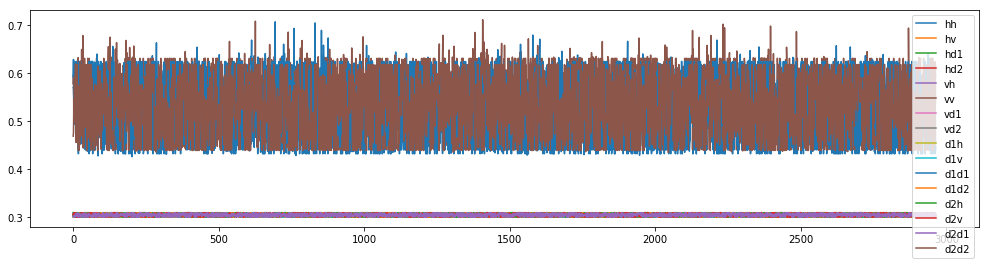

4765

In [16]:
plot_lateral_distribution('L3_L3')
gc.collect()

hh 3201.8569873491497 of 51232.06893488719 : 6.249712443622983
hv 3202.077338336623 of 51232.06893488719 : 6.2501425472515395
hd1 3202.113960404605 of 51232.06893488719 : 6.250214029955134
hd2 3201.9707655705415 of 51232.06893488719 : 6.249934527610137
vh 3201.953792378267 of 51232.06893488719 : 6.249901397594841
vv 3201.995694371534 of 51232.06893488719 : 6.249983186197445
vd1 3202.046175042411 of 51232.06893488719 : 6.250081719541749
vd2 3201.971871490265 of 51232.06893488719 : 6.249936686257536
d1h 3202.0327931833676 of 51232.06893488719 : 6.250055599458523
d1v 3202.079382280689 of 51232.06893488719 : 6.250146536830936
d1d1 3202.04465825951 of 51232.06893488719 : 6.250078758929514
d1d2 3201.972754752803 of 51232.06893488719 : 6.249938410299833
d2h 3202.1176009302976 of 51232.06893488719 : 6.250221135906091
d2v 3201.915946571224 of 51232.06893488719 : 6.2498275262719964
d2d1 3201.964090980412 of 51232.06893488719 : 6.249921499461424
d2d2 3201.9551229853814 of 51232.06893488719 : 6.24

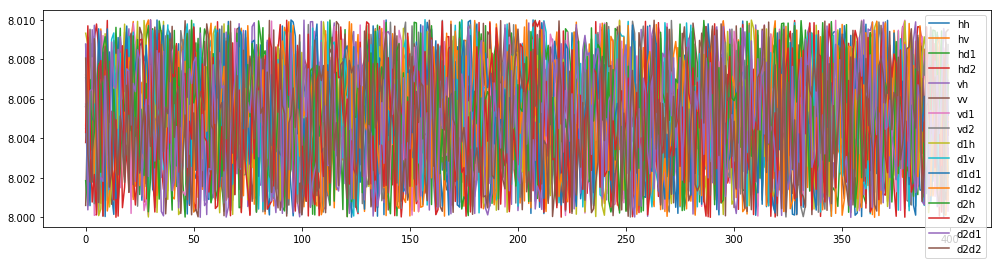

4932

In [17]:
plot_lateral_distribution('L3_L2')
gc.collect()

# TRAIN

In [18]:
previous_spike_count = np.zeros(n_L4)
input_groups['input'].rates = 0 * Hz

selected_orientations = [h_index, v_index, d1_index, d2_index, h_index, v_index, d1_index, d2_index]

for o_index in selected_orientations: 
    net.run(resting_time)
    
    for name, e_i in neuron_groups_list:
        if (e_i == 'e'):
            neuron_groups[name].theta = np.ones((n_L4)) * 20.0*mV
            
    # load stimuli
    prenatal_stimuli = get_prenatal_signals((c_length,c_length,orientations), o_index)

    j = 0
    while j < (num_epochs):
        if ((j+1) % normalize_interval == 0):
            normalize_weights(o_index)
        
        spike_rates = prenatal_stimuli.reshape((n_L4)) / 8. *  input_intensity
        input_groups['input'].rates = spike_rates * Hz

        print('run example number:', j+1, 'of', num_epochs, 'in iteration', o_index, 'of', len(selected_orientations))
        
        net.run(single_example_time, report='text')   # 0.35 s

        current_spike_count = np.asarray(spike_monitors['L4'].count[:]) - previous_spike_count
        previous_spike_count = np.copy(spike_monitors['L4'].count[:])
        
        input_groups['input'].rates = 0 * Hz
        net.run(resting_time) 

        if np.sum(current_spike_count) < 1:
            if (input_intensity == 5):
                break;
            print("F - spike count", np.sum(current_spike_count))
            input_intensity += 1
        else:     
            print("S - spike count", np.sum(current_spike_count))
            input_intensity = start_input_intensity
            j += 1

        # garbage collect after each iteration
        gc.collect()

run example number: 1 of 60 in iteration 0 of 8
Starting simulation at t=250. ms for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 262.0
run example number: 2 of 60 in iteration 0 of 8
Starting simulation at t=0.95 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 275
run example number: 3 of 60 in iteration 0 of 8
Starting simulation at t=1.65 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 267
run example number: 4 of 60 in iteration 0 of 8
Starting simulation at t=2.35 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 281
run example number: 5 of 60 in iteration 0 of 8
Starting simulation at t=3.05 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 703
run example number: 6 of 60 in iteration 0 of 8
Starting simulation at t=3.75 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 278
run example number: 7 of 60 in iteration 0 of 8
Starting simulation at t=4.45 s

Starting simulation at t=37.35 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 261
run example number: 55 of 60 in iteration 0 of 8
Starting simulation at t=38.05 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 181
run example number: 56 of 60 in iteration 0 of 8
Starting simulation at t=38.75 s for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 124
run example number: 57 of 60 in iteration 0 of 8
Starting simulation at t=39.45 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 136
run example number: 58 of 60 in iteration 0 of 8
Starting simulation at t=40.15 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 130
run example number: 59 of 60 in iteration 0 of 8
Starting simulation at t=40.85 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 119
run example number: 60 of 60 in iteration 0 of 8
Starting simulation at t=41.55 s for a duration of 0.45 s
0.45 (100%) 

0.45 (100%) simulated in 4s
S - spike count 253
run example number: 48 of 60 in iteration 1 of 8
Starting simulation at t=75.4 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 214
run example number: 49 of 60 in iteration 1 of 8
Starting simulation at t=76.1 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 286
run example number: 50 of 60 in iteration 1 of 8
Starting simulation at t=76.8 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 212
run example number: 51 of 60 in iteration 1 of 8
Starting simulation at t=77.5 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 234
run example number: 52 of 60 in iteration 1 of 8
Starting simulation at t=78.2 s for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 139
run example number: 53 of 60 in iteration 1 of 8
Starting simulation at t=78.9 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 206
run example number: 54 of 60

0.45 (100%) simulated in 5s
S - spike count 469
run example number: 41 of 60 in iteration 2 of 8
Starting simulation at t=112.75 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 360
run example number: 42 of 60 in iteration 2 of 8
Starting simulation at t=113.45 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 333
run example number: 43 of 60 in iteration 2 of 8
Starting simulation at t=114.15 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 318
run example number: 44 of 60 in iteration 2 of 8
Starting simulation at t=114.85 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 269
run example number: 45 of 60 in iteration 2 of 8
Starting simulation at t=115.55 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 259
run example number: 46 of 60 in iteration 2 of 8
Starting simulation at t=116.25 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 293
run example numb

0.45 (100%) simulated in 5s
S - spike count 423
run example number: 34 of 60 in iteration 3 of 8
Starting simulation at t=150.1 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 518
run example number: 35 of 60 in iteration 3 of 8
Starting simulation at t=150.8 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 407
run example number: 36 of 60 in iteration 3 of 8
Starting simulation at t=151.5 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 307
run example number: 37 of 60 in iteration 3 of 8
Starting simulation at t=152.2 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 369
run example number: 38 of 60 in iteration 3 of 8
Starting simulation at t=152.9 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 355
run example number: 39 of 60 in iteration 3 of 8
Starting simulation at t=153.6 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 269
run example number: 40

0.45 (100%) simulated in 9s
S - spike count 585
run example number: 25 of 60 in iteration 0 of 8
Starting simulation at t=186.05 s for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 543
run example number: 26 of 60 in iteration 0 of 8
Starting simulation at t=186.75 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 592
run example number: 27 of 60 in iteration 0 of 8
Starting simulation at t=187.45 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 557
run example number: 28 of 60 in iteration 0 of 8
Starting simulation at t=188.15 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 540
run example number: 29 of 60 in iteration 0 of 8
Starting simulation at t=188.85 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 554
run example number: 30 of 60 in iteration 0 of 8
Starting simulation at t=189.55 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 424
run example numb

Starting simulation at t=222.7 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 745
run example number: 18 of 60 in iteration 1 of 8
Starting simulation at t=223.4 s for a duration of 0.45 s
0.45 (100%) simulated in 7s
S - spike count 713
run example number: 19 of 60 in iteration 1 of 8
Starting simulation at t=224.1 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 683
run example number: 20 of 60 in iteration 1 of 8
Starting simulation at t=224.8 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 644
run example number: 21 of 60 in iteration 1 of 8
Starting simulation at t=225.5 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 639
run example number: 22 of 60 in iteration 1 of 8
Starting simulation at t=226.2 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 604
run example number: 23 of 60 in iteration 1 of 8
Starting simulation at t=226.9 s for a duration of 0.45 s
0.45 (100%) 

Starting simulation at t=260.05 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 1074
run example number: 11 of 60 in iteration 2 of 8
Starting simulation at t=260.75 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 1030
run example number: 12 of 60 in iteration 2 of 8
Starting simulation at t=261.45 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 983
run example number: 13 of 60 in iteration 2 of 8
Starting simulation at t=262.15 s for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 948
run example number: 14 of 60 in iteration 2 of 8
Starting simulation at t=262.85 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 898
run example number: 15 of 60 in iteration 2 of 8
Starting simulation at t=263.55 s for a duration of 0.45 s
0.45 (100%) simulated in 8s
S - spike count 857
run example number: 16 of 60 in iteration 2 of 8
Starting simulation at t=264.25 s for a duration of 0.45 s
0.4

S - spike count 1107
run example number: 3 of 60 in iteration 3 of 8
Starting simulation at t=297.4 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 1101
run example number: 4 of 60 in iteration 3 of 8
Starting simulation at t=298.1 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 1100
run example number: 5 of 60 in iteration 3 of 8
Starting simulation at t=298.8 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 1090
run example number: 6 of 60 in iteration 3 of 8
Starting simulation at t=299.5 s for a duration of 0.45 s
0.45 (100%) simulated in 7s
S - spike count 1093
run example number: 7 of 60 in iteration 3 of 8
Starting simulation at t=300.2 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 1088
run example number: 8 of 60 in iteration 3 of 8
Starting simulation at t=300.9 s for a duration of 0.45 s
0.45 (100%) simulated in 7s
S - spike count 1077
run example number: 9 of 60 in iteration 3 of 8
S

0.45 (100%) simulated in 5s
S - spike count 198
run example number: 56 of 60 in iteration 3 of 8
Starting simulation at t=0.3345 ks for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 117
run example number: 57 of 60 in iteration 3 of 8
Starting simulation at t=0.3352 ks for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 115
run example number: 58 of 60 in iteration 3 of 8
Starting simulation at t=0.3359 ks for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 212
run example number: 59 of 60 in iteration 3 of 8
Starting simulation at t=0.3366 ks for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 200
run example number: 60 of 60 in iteration 3 of 8
Starting simulation at t=0.3373 ks for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 221


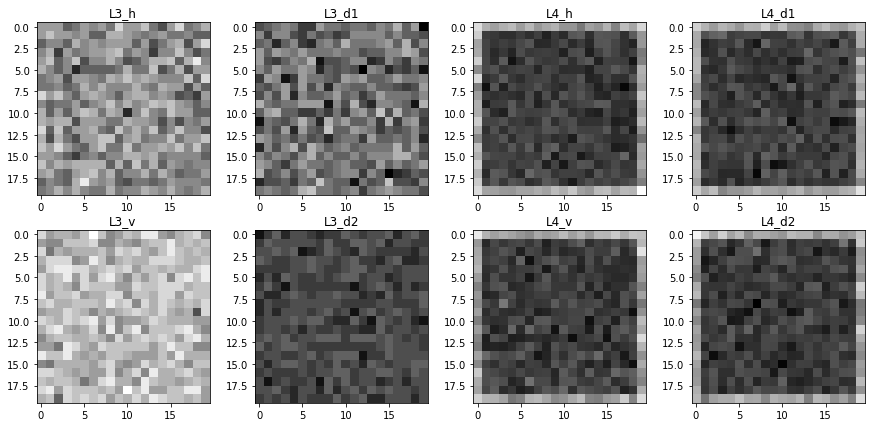

In [19]:
c_shape = (c_length, c_length, orientations)
fig, axarr = subplots(2,4, figsize = (15, 7))

data = np.copy(spike_monitors['L3'].count).reshape(c_shape).transpose()
v_min = data.min(); v_max = data.max()

axarr[0,0].imshow(data[h_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,0].title.set_text('L3_h')
axarr[1,0].imshow(data[v_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,0].title.set_text('L3_v')
axarr[0,1].imshow(data[d1_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,1].title.set_text('L3_d1')
axarr[1,1].imshow(data[d2_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,1].title.set_text('L3_d2')


data = np.copy(spike_monitors['L4'].count).reshape(c_shape).transpose()
v_min = data.min(); v_max = data.max()

axarr[0,2].imshow(data[h_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,2].title.set_text('L4_h')
axarr[1,2].imshow(data[v_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,2].title.set_text('L4_v')
axarr[0,3].imshow(data[d1_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,3].title.set_text('L4_d1')
axarr[1,3].imshow(data[d2_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,3].title.set_text('L4_d2')

In [20]:
gc.collect()

30

hh 27186.224578514146 of 120430.47196233147 : 22.574207453922057
hv 903.7135760191253 of 120430.47196233147 : 0.7504027521388366
hd1 904.1034218445824 of 120430.47196233147 : 0.750726462425033
hd2 904.234573955236 of 120430.47196233147 : 0.7508353651873627
vh 904.0060878510484 of 120430.47196233147 : 0.7506456406928352
vv 27042.769732719928 of 120430.47196233147 : 22.45508905850542
vd1 903.9725717694303 of 120430.47196233147 : 0.7506178104592806
vd2 903.933209832549 of 120430.47196233147 : 0.7505851260927412
d1h 904.0146475249384 of 120430.47196233147 : 0.7506527482576819
d1v 904.0075290047552 of 120430.47196233147 : 0.7506468373614884
d1d1 27380.330354069283 of 120430.47196233147 : 22.73538408338495
d1d2 904.4798123688904 of 120430.47196233147 : 0.751039000039621
d2h 904.169196713287 of 120430.47196233147 : 0.7507810788918067
d2v 904.1521692062959 of 120430.47196233147 : 0.7507669400225373
d2d1 904.0140777400336 of 120430.47196233147 : 0.7506522751341481
d2d2 27972.346423193467 of 120

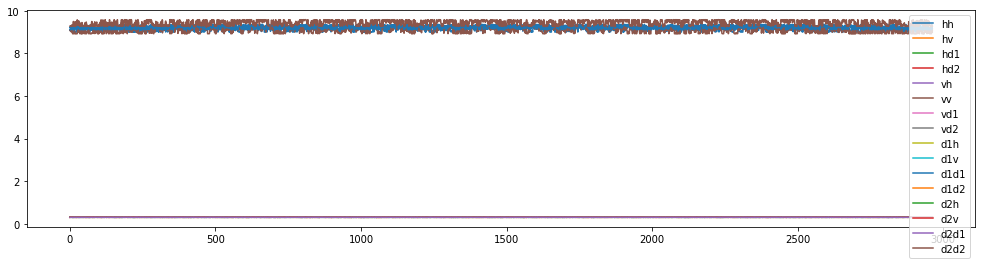

In [21]:
plot_lateral_distribution('L3_L3')

hh 3201.8569873491497 of 51232.06893488719 : 6.249712443622983
hv 3202.077338336623 of 51232.06893488719 : 6.2501425472515395
hd1 3202.113960404605 of 51232.06893488719 : 6.250214029955134
hd2 3201.9707655705415 of 51232.06893488719 : 6.249934527610137
vh 3201.953792378267 of 51232.06893488719 : 6.249901397594841
vv 3201.995694371534 of 51232.06893488719 : 6.249983186197445
vd1 3202.046175042411 of 51232.06893488719 : 6.250081719541749
vd2 3201.971871490265 of 51232.06893488719 : 6.249936686257536
d1h 3202.0327931833676 of 51232.06893488719 : 6.250055599458523
d1v 3202.079382280689 of 51232.06893488719 : 6.250146536830936
d1d1 3202.04465825951 of 51232.06893488719 : 6.250078758929514
d1d2 3201.972754752803 of 51232.06893488719 : 6.249938410299833
d2h 3202.1176009302976 of 51232.06893488719 : 6.250221135906091
d2v 3201.915946571224 of 51232.06893488719 : 6.2498275262719964
d2d1 3201.964090980412 of 51232.06893488719 : 6.249921499461424
d2d2 3201.9551229853814 of 51232.06893488719 : 6.24

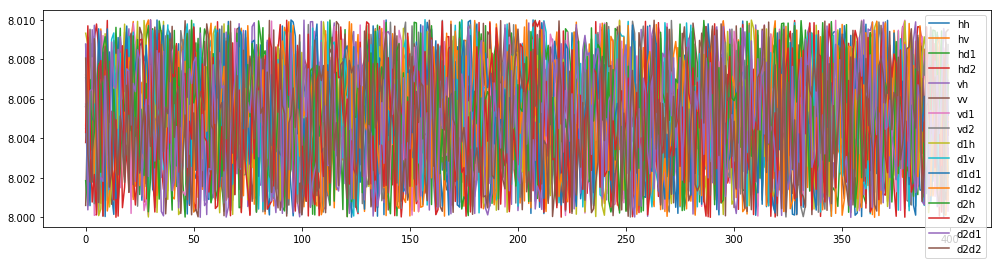

In [22]:
plot_lateral_distribution('L3_L2')

In [23]:
# save connections
save_connections()

input_L4 L4_L3 L3_L3 L3_L2 L2_L3 L3_L4 connections saved


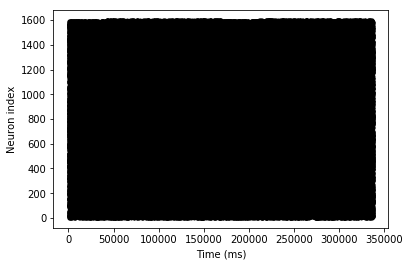

In [24]:
plot(spike_monitors['input'].t/ms, spike_monitors['input'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

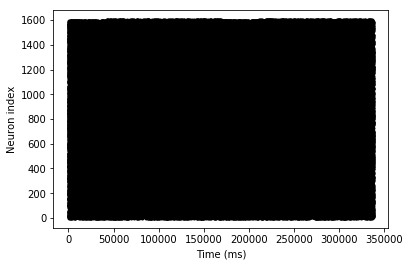

In [25]:
plot(spike_monitors['L4'].t/ms, spike_monitors['L4'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

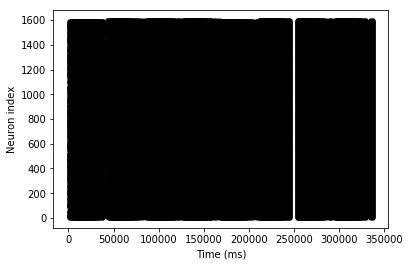

In [26]:
plot(spike_monitors['L3'].t/ms, spike_monitors['L3'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

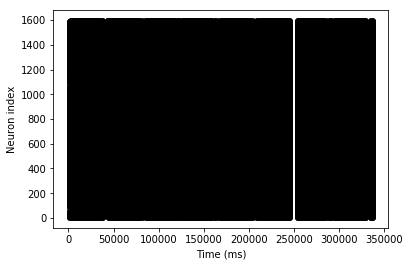

In [27]:
plot(spike_monitors['L2'].t/ms, spike_monitors['L2'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

In [28]:
gc.collect()

19905

In [29]:
# figure(figsize=(15, 4))
# plot(M['L2'].t/ms, M['L2'].v[8], label='L2')
# plot(M['L3'].t/ms, M['L3'].v[8], label='L3')
# legend()

In [30]:
unique(connections['L3_L3'].w)

array([-1.50501917e-17, -1.50128255e-17, -1.50126132e-17, ...,
        1.60489443e+01,  1.61698248e+01,  1.63277672e+01])

In [31]:
unique(connections['L3_L2'].w)

array([0.        , 8.00000144, 8.00000333, ..., 8.00998927, 8.0099917 ,
       8.00999933])